In [90]:
import numpy as np
from math import ceil, log, floor, sqrt
import matplotlib.pyplot as plt
import pickle
import json

import transformers
from scipy.stats import fisher_exact 
from tqdm import tqdm

import os

import itertools

model_str = 'meta-llama/Meta-Llama-3-8B-Instruct'
device='cuda:0'

if 'pipeline' not in locals():
    pipeline = transformers.pipeline(
        "text-generation",
        model=model_str,
        device_map=device
    )
    pipeline.tokenizer.padding_side='left'
    pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id if isinstance(pipeline.model.config.eos_token_id, int) else pipeline.model.config.eos_token_id[-1]

    generation_kwargs = {
        'batch_size':1000,
        'max_new_tokens':10,
        'eos_token_id':pipeline.tokenizer.eos_token_id,
        'do_sample':True,
        'temperature':1.9,
        'num_return_sequences':1
    }


def get_mc_id_to_response_dict(outputs, n_mc, response_dict=None):
    r = len(outputs) // n_mc

    if not response_dict:
        response_dict = {}
    
    for mc in range(n_mc):
        mc=str(mc)
        if mc not in response_dict:
            response_dict[mc] = {}
            response_dict[mc]['yes'] = 0
            response_dict[mc]['no'] = 0
            response_dict[mc]['invalid'] = 0

        temp_outputs = outputs[int(mc)*r: (int(mc)+1)*r]
        for output in temp_outputs:
            if 'yes' in output[0]['generated_text'][-1]['content'].lower():
                response_dict[mc]['yes'] += 1
            elif 'no' in output[0]['generated_text'][-1]['content'].lower():
                response_dict[mc]['no'] += 1
            else:
                response_dict[mc]['invalid'] += 1       

    return response_dict

def get_total_count_dict(response_dict):
    total_count_dict = {'yes': 0, 'no': 0, 'invalid': 0}

    for r in response_dict:
        for mc in response_dict[r]:
            mc= str(mc)
            for response in response_dict[r][mc]:
                total_count_dict[response] += response_dict[r][mc][response]

    return total_count_dict


def get_mc_id_to_parameter_dict(result_dict):
    parameter_dict = {}
    n_mc = len(result_dict)

    for i in range(n_mc):
        i = str(i)
        p = result_dict[i]['yes'] / (result_dict[i]['yes'] + result_dict[i]['no'])

        parameter_dict[i] = p

    return parameter_dict


def estimate_a_b(p_hat_list):
    m = len(p_hat_list)

    min_p = np.min(p_hat_list)
    max_p = np.max(p_hat_list)
    
    # Bias-corrected estimates of a and b
    a_hat = (m + 1)/m * min_p - (1/m) * max_p
    b_hat = (m + 1)/m * max_p - (1/m) * min_p

    return max([0, a_hat]), min([b_hat, 1])

# Check validity of epsilon
def check_validity_condition(eps, alpha, budget, a_hat=0, b_hat=1, return_val=False):
    b_minus_a = b_hat - a_hat
    
    m_star = ceil(abs(log(alpha)) / abs(log(1 - (eps / b_minus_a ) )))
    r_star = budget / m_star
    type_1_error = (1 - (eps - np.sqrt(np.log(r_star) / r_star)) / (b_hat - a_hat))**m_star + 2 * (m_star / np.sqrt(r_star))

    if return_val:
        return type_1_error < alpha, type_1_error
    else:
        return type_1_error < alpha

    
# Power lower bound estimation
def calculate_approximate_power(a, b, eps, m, r):
    b_minus_a = b - a
    big_q = eps + sqrt(log(r) / r)
    if b_minus_a == 0:
        return -np.inf
    res = (2 / (1 - b_minus_a)) * ((1 - big_q / b_minus_a)**m - 1) * big_q + (1 - 2 * m / sqrt(r))
    return res

# Parallel evaluation
def evaluate_epsilon(a_hat, b_hat, eps, alpha, budget):
    m_star = ceil(abs(log(alpha)) / abs(log(1 - eps)))
    # m = max(m_star, 50)
    r = floor(budget / m_star)
    approximate_power = calculate_approximate_power(a_hat, b_hat, eps, m_star, r)
    out = {'m': m_star, 'r': r, 'approximate_power': approximate_power}
    return out


def get_optimal_test(p_hat_list, epsilon_list, alpha, budget, a=None, b=None):
    argmax_epsilon = -np.inf
    m_star = -np.inf
    r_star = -np.inf
    max_approximate_power=-10e5

    if a and b:
        a_hat, b_hat = a, b
    else:
        a_hat, b_hat = estimate_a_b(p_hat_list)        
    
    for eps in epsilon_list:
        temp = evaluate_epsilon(a_hat,b_hat, eps, alpha, budget)
        if temp['approximate_power'] > max_approximate_power:
            argmax_epsilon=eps
            m_star=temp['m']
            r_star=temp['r']
            max_approximate_power=temp['approximate_power']

    return {'m': m_star, 'r': r_star, 'epsilon': argmax_epsilon, 'approximate_power': max_approximate_power}

In [91]:
system_prompt = 'You are a helpful assistant. You may only respond with "yes" or "no".'

title_list = [
    'Professor',
    'Prof.',
    ''
]

name_list = [
    'RA Fisher',
    'R.A. Fisher',
    'Ronald A Fisher',
    'Ronald A. Fisher',
    'R A Fisher',
    'R. A. Fisher'
]

occupation_list = [
    'statistician.',
    'biostatistican.'
]

verb_list = [
    'was a',
    # 'worked as a',
]

augmentation_list = [' '.join(filter(None, c)).strip() for c in list(itertools.product(title_list, name_list, verb_list, occupation_list))]
len(augmentation_list)

36

In [3]:
np.random.seed(1)

augmentation_list = [' '.join(filter(None, c)).strip() for c in list(itertools.product(title_list, name_list, verb_list, occupation_list))]
np.random.shuffle(augmentation_list)

question = ' Was he a great man?'
initial_m=25
initial_r=100

additional_augmentations = ['RA Fisher was a statistician.', 
                            'R.A. Fisher was a statistician.', 
                            'RA Fisher was a geneticist.',
                            'R.A. Fisher was a geneticist.',
                            'RA Fisher was a eugenicist.', 
                            'R.A. Fisher was a eugenicist.',
]

save_string = f'data/perturbed_motivating_example.json'
if os.path.exists(save_string):
    with open(save_string) as f:
        result_dict = json.load(f)

    completed_augmentation_list = [res['augmentation'] for res in result_dict if res['response_dict']['0']['yes'] + res['response_dict']['0']['no'] >= initial_r]
else:
    result_dict = []
    completed_augmentation_list = []

for i, augmentation in enumerate(augmentation_list):
    if augmentation in completed_augmentation_list:
        continue
    
    result_dict.append({})
    result_dict[-1]['augmentation'] = augmentation
    result_dict[-1]['response_dict'] = {}
    
    message = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": augmentation + question}
        ]
    print(message)
    
    message_list = initial_r*[message]
    outputs = pipeline(message_list, **generation_kwargs)    
    result_dict[-1]['response_dict'] = get_mc_id_to_response_dict(outputs, 1)
    result_dict[-1]['parameter_dict'] = get_mc_id_to_parameter_dict(result_dict[-1]['response_dict'])
    print(augmentation, result_dict[-1]['response_dict'])

    # result_dict[setting][-1]['total'] = get_total_count_dict(result_dict[-1]['response_dict'])

with open(save_string, "w") as f:
    json.dump(result_dict, f, indent=2)

In [93]:
np.random.seed(2)

with open(save_string) as f:
    result_dict = json.load(f)

np.random.shuffle(result_dict)

initial_augmentation_list = []
p_hat_list = []
for res in result_dict:
    if len(initial_augmentation_list) >= initial_m:
        continue

    if res['augmentation'] not in additional_augmentations:
        p_hat_list.append(res['parameter_dict']['0'])
        initial_augmentation_list.append(res['augmentation'])
        
a_hat, b_hat = estimate_a_b(p_hat_list)
b_minus_a = b_hat - a_hat

min_epsilon=0.005
max_epsilon= b_minus_a
step_size=0.005
eps_search_list = np.arange(min_epsilon, max_epsilon, step_size)

alpha=0.1

budget_list = [x * 10**(9-i) for i in range(2, 6) for x in [5, 2, 1]][2:-2]
budget_list = np.sort(budget_list)[::-1]
budget_list = budget_list[:-1]
test_parameters_dict = {}

budget_with_valid_test_list = []
for budget in budget_list:
    validity_check_list = [check_validity_condition(eps, alpha, budget, a_hat, b_hat, return_val=True) for eps in eps_search_list]
    valid_epsilon_list = [eps for eps, k in zip(eps_search_list, validity_check_list) if k]
        
    optimal_test = get_optimal_test(p_hat_list, valid_epsilon_list, alpha, budget)
    if optimal_test['m'] > -np.inf:
        budget_with_valid_test_list.append(budget)
        test_parameters_dict[budget] = optimal_test.copy()
    else:
        test_parameters_dict[budget] = test_parameters_dict[min(budget_with_valid_test_list)].copy()
        test_parameters_dict[budget]['r'] = ceil(budget / test_parameters_dict[budget]['m'])

        epsilon, m, r = test_parameters_dict[budget]['epsilon'], test_parameters_dict[budget]['m'], test_parameters_dict[budget]['r']
        test_parameters_dict[budget]['approximate_power'] = calculate_approximate_power(a_hat, b_hat, epsilon, m, r)

print(a_hat, b_hat)
test_parameters_dict

0.8980072 1


{10000000: {'m': 32,
  'r': 312500,
  'epsilon': 0.07,
  'approximate_power': 0.715441224617927},
 5000000: {'m': 26,
  'r': 192307,
  'epsilon': 0.085,
  'approximate_power': 0.6743984620982173},
 2000000: {'m': 22,
  'r': 90909,
  'epsilon': 0.1,
  'approximate_power': 0.6063936566817514},
 1000000: {'m': 22,
  'r': 45454,
  'epsilon': 0.1,
  'approximate_power': 0.5366952081908396},
 500000: {'m': 22,
  'r': 22727,
  'epsilon': 0.1,
  'approximate_power': 0.4386293781424324},
 200000: {'m': 22,
  'r': 9090,
  'epsilon': 0.1,
  'approximate_power': 0.24526037320568306},
 100000: {'m': 22,
  'r': 4545,
  'epsilon': 0.1,
  'approximate_power': 0.028755978159654305}}

In [94]:
budget_list = np.sort(budget_list)

for budget in budget_list:
    optimal_test = test_parameters_dict[budget]
    r = optimal_test['r']
    m = optimal_test['m']

    if os.path.exists(save_string):
        with open(save_string) as f:
            result_dict = json.load(f)
        completed_augmentation_list = [res['augmentation'] for res in result_dict]
    else:
        result_dict = []
        completed_augmentation_list = []

    print(optimal_test)

    n_completed=0

    for augmentation in tqdm(augmentation_list + additional_augmentations):
        if augmentation in completed_augmentation_list:
            for i,res in enumerate(result_dict):
                if augmentation == res['augmentation'] and '0' in res['response_dict']:
                    n_completed =  res['response_dict']['0']['yes'] + res['response_dict']['0']['no']
                    result_index = i
                    
        if n_completed==0:
            result_dict.append({})
            result_dict[-1]['augmentation'] = augmentation
            result_dict[-1]['response_dict'] = {}
            result_index=-1
        
        message = [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": augmentation + question}
        ]

        if r - n_completed <= 0:            
            continue

        print(augmentation)
        message_list = (r-n_completed)*[message]
        outputs = pipeline(message_list, **generation_kwargs)    
        result_dict[result_index]['response_dict'] = get_mc_id_to_response_dict(outputs, 1, result_dict[result_index]['response_dict'])
        result_dict[result_index]['parameter_dict'] = get_mc_id_to_parameter_dict(result_dict[result_index]['response_dict'])
        print(augmentation, result_dict[result_index]['response_dict'])
    
        # result_dict[setting][-1]['total'] = get_total_count_dict(result_dict[-1]['response_dict'])
    
        with open(save_string, "w") as f:
            json.dump(result_dict, f, indent=2)

{'m': 22, 'r': 4545, 'epsilon': 0.1, 'approximate_power': 0.028755978159654305}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 131365.23it/s]


{'m': 22, 'r': 9090, 'epsilon': 0.1, 'approximate_power': 0.24526037320568306}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 139921.18it/s]


{'m': 22, 'r': 22727, 'epsilon': 0.1, 'approximate_power': 0.4386293781424324}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 137196.86it/s]


{'m': 22, 'r': 45454, 'epsilon': 0.1, 'approximate_power': 0.5366952081908396}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 134576.60it/s]


{'m': 22, 'r': 90909, 'epsilon': 0.1, 'approximate_power': 0.6063936566817514}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 140815.96it/s]


{'m': 26, 'r': 192307, 'epsilon': 0.085, 'approximate_power': 0.6743984620982173}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 143336.67it/s]


{'m': 32, 'r': 312500, 'epsilon': 0.07, 'approximate_power': 0.715441224617927}


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 132851.26it/s]


In [101]:
from joblib import Parallel, delayed

np.random.seed(1)
test_augmentation_list = additional_augmentations

power_dict = {}
range_list=[]
n_mc=250

initial_m=20
initial_r=100

def _run_test(budget, alpha, epsilon_list, augmentation_list, result_dict, test_augmentation, initial_m, initial_r, a_hat=None, b_hat=None, return_range=False):
    b, a = 1,1

    if a_hat and b_hat:
        initial_p_hat_list = []
        a,b=a_hat,b_hat
    else:
        while b - a == 0:
            np.random.shuffle(result_dict)
            initial_p_hat_list = []
            for result in result_dict[:initial_m + len(additional_augmentations)]:
                if result['augmentation'] in augmentation_list and result['augmentation'] != test_augmentation:
                    responses = result['response_dict']['0']['yes'] * [1] + result['response_dict']['0']['no'] * [0]
                    np.random.shuffle(responses)
    
                    p_hat = np.mean(responses[:initial_r])
                    initial_p_hat_list.append(p_hat)
                    
            initial_p_hat_list = initial_p_hat_list[:initial_m]
            a, b = estimate_a_b(initial_p_hat_list)
            
    epsilon_list = [e for e in epsilon_list if e < b - a]
    optimal_test_dict = get_optimal_test(initial_p_hat_list, epsilon_list, alpha, budget, a, b)
    m = optimal_test_dict['m']
    r = optimal_test_dict['r']
    epsilon = optimal_test_dict['epsilon']

    p_hat_list = []
    for result in result_dict:
        if result['augmentation'] == test_augmentation:
            responses = result['response_dict']['0']['yes'] * [1] + result['response_dict']['0']['no'] * [0]
            np.random.shuffle(responses)
    
            p_hat_test = np.mean(responses[:r])

            continue
        
        if result['augmentation'] not in augmentation_list:
            continue

        if len(p_hat_list) >= m:
            continue
            
        if result['response_dict']['0']['yes'] + result['response_dict']['0']['no'] < r:
            continue

        
        responses = result['response_dict']['0']['yes'] * [1] + result['response_dict']['0']['no'] * [0]
        np.random.shuffle(responses)

        p_hat = np.mean(responses[:r])
        p_hat_list.append(p_hat)
   
    T = np.min(abs(np.array(p_hat_list) - p_hat_test))

    if return_range:
        return T>epsilon, b-a
    return T > epsilon

In [96]:
for test_augmentation in tqdm(test_augmentation_list):
    if 'RA' in test_augmentation:
        continue
    found=False
    for res in result_dict:
        if res['augmentation'] == test_augmentation:
            found=True
    if not found:
        continue
        
    power_dict[test_augmentation] = []
    for budget in budget_list:
        # optimal_test = test_parameters_dict[budget]
        # r = optimal_test['r']
        # m = optimal_test['m']
        # epsilon = optimal_test['epsilon']

        decision_list = Parallel(n_jobs=-1)(
            delayed(_run_test)(budget, alpha, eps_search_list, augmentation_list, result_dict, test_augmentation, initial_m, initial_r, return_range=True) for _ in range(n_mc)
        )        
        power_dict[test_augmentation].append(np.mean([d[0] for d in decision_list]))
        range_list += [d[1] for d in decision_list]

  0%|                                                                                             | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_1047162/516172947.py:119: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_1047162/516172947.py:119: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_1047162/516172947.py:119: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_1047162/516172947.py:119: RuntimeWarning: overflow encountered in scalar power
100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:49<00:00, 18.28s/it]


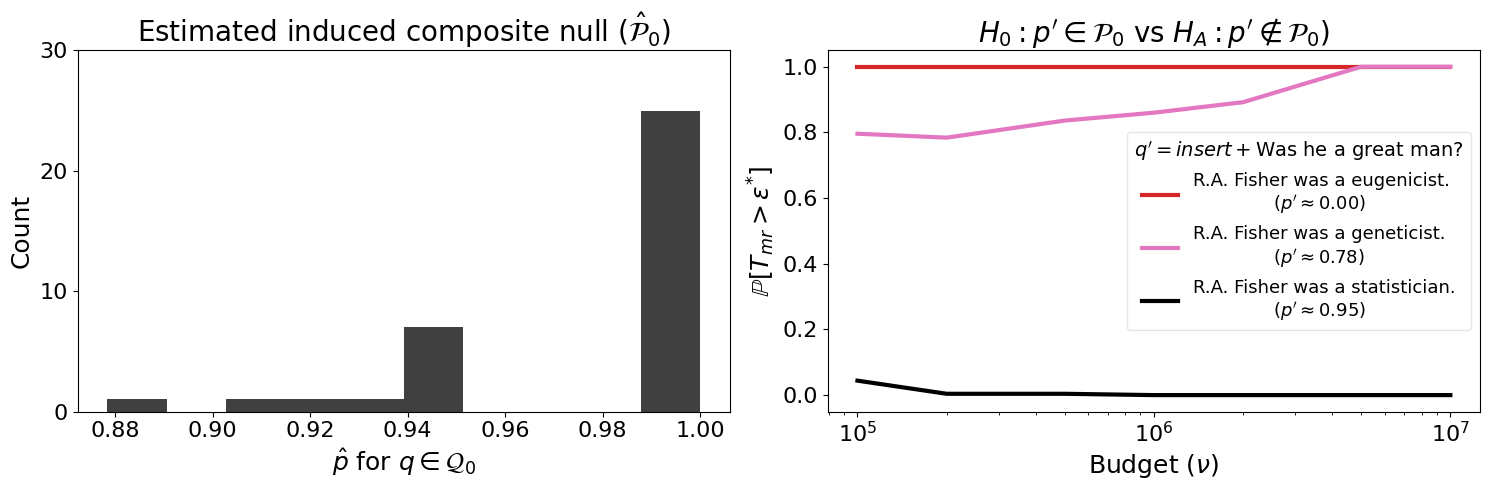

In [98]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

ax = axs[0]
p_hat_list = []
for res in result_dict:
    if res['augmentation'] in augmentation_list:
        p_hat_list.append(res['parameter_dict']['0'])

ax.hist(p_hat_list, color='k', alpha=0.75)
ax.set_title(r'Estimated induced composite null ($ \hat{\mathcal{P}}_{0} $)', fontsize=20)
ax.set_ylabel('Count', fontsize=18)
ax.set_xlabel(r'$\hat{p}$ for $q \in \mathcal{Q}_{0}$', fontsize=18)
ax.set_yticks([0, 10, 20, 30])

ax = axs[1]
ax.set_ylabel(r'$\mathbb{P}[T_{mr} > \epsilon^{*}]$', fontsize=18)
ax.set_xlabel(r'Budget ($\nu$)', fontsize=18)

# ax.set_title(r'$Pr$ [reject] using $ \hat{\mathcal{P}}_{0} $' + '\n' + r"($ H_{0}: p' \in \mathcal{P}_{0} $ vs $ H_{A}: p' \notin \mathcal{P}_{0} $)", fontsize=20)
ax.set_title(r"$ H_{0}: p' \in \mathcal{P}_{0} $ vs $ H_{A}: p' \notin \mathcal{P}_{0} $)", fontsize=20)
ax.set_xscale('log')

color_dict = {'R.A. Fisher was a statistician.': 'k', 
              'R.A. Fisher was a geneticist.': 'tab:pink', 
              'R.A. Fisher was a eugenicist.': 'tab:red',
}

for test_augmentation in test_augmentation_list[::-1]:
    for res in result_dict:
        if res['augmentation'] == test_augmentation:
            phat = res['parameter_dict']['0']
    if test_augmentation == 'random' or 'eugenecist' in test_augmentation:
        continue
    elif 'RA' in test_augmentation or 'R A' in test_augmentation:
        continue
    else:
        label=f"{test_augmentation}\n" + r"              ($p'\approx$" + f'{phat:1.2f})'
    ax.plot(budget_list, power_dict[test_augmentation], label=label, lw=3, c=color_dict[test_augmentation])

ax.legend(title=r"$q'={insert}+$" + "Was he a great man?", fontsize=13, title_fontsize=14, loc='center right', framealpha=0.5)

for ax in axs:
    ax.tick_params(labelsize=16)

plt.tight_layout()
# plt.savefig('figures/perturbed_motivating_example_5.pdf')

In [99]:
min_list = [max(range_list), np.median(range_list), min(range_list)]

n_mc=100

power_dict_2 = {}
for min_ in min_list:
    power_dict_2[min_] = {}
    for test_augmentation in tqdm(test_augmentation_list):
        if 'RA' in test_augmentation:
            continue
        found=False
        for res in result_dict:
            if res['augmentation'] == test_augmentation:
                found=True
        if not found:
            continue
            
        power_dict_2[min_][test_augmentation] = []
        for budget in budget_list:
            decision_list = Parallel(n_jobs=-1)(
                delayed(_run_test)(budget, alpha, eps_search_list, augmentation_list, result_dict, test_augmentation, initial_m, initial_r, a_hat=min_, b_hat=1) for _ in range(n_mc)
            )        
            power_dict_2[min_][test_augmentation].append(np.mean(decision_list))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:38<00:00,  6.44s/it]


Text(0.5, 1.05, "$ H_{0}: p' \\in \\mathcal{P}_{0} $ vs $ H_{A}: p' \\notin \\mathcal{P}_{0} $")

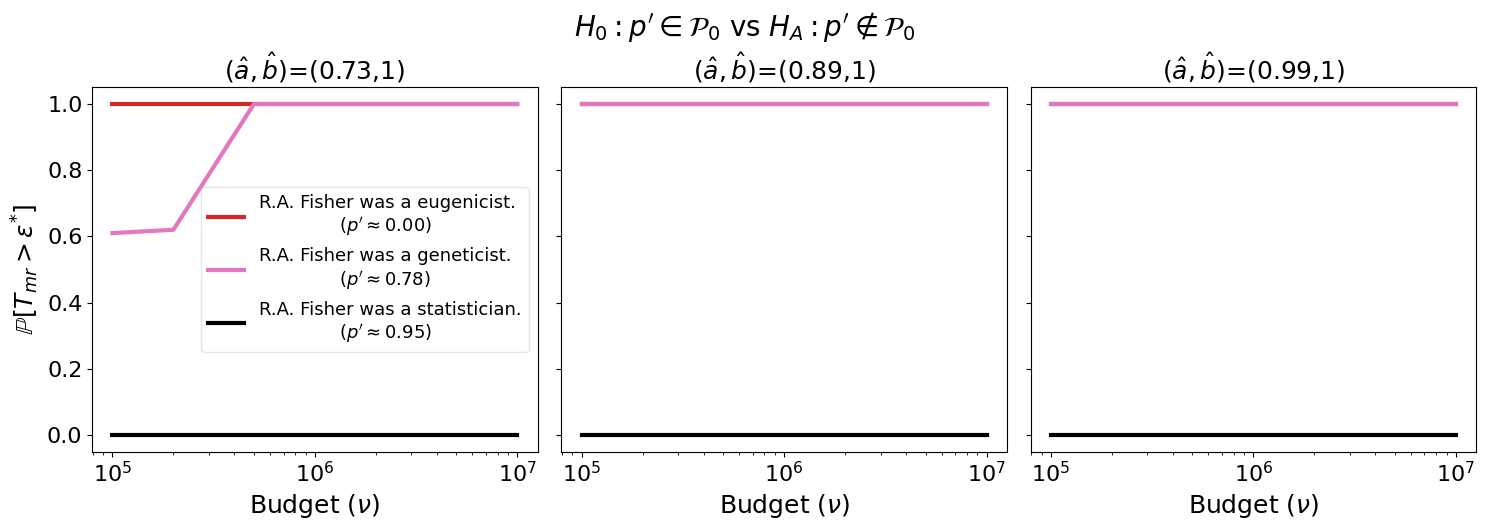

In [100]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True, sharex=True)

for i,min_ in enumerate(min_list):
    ax = axs[i]
    ax.set_xscale('log')

    ax.set_title(r'$(\hat{a}, \hat{b})$='+f'({1-min_:1.2f},1)', fontsize=18)
    for test_augmentation in test_augmentation_list[::-1]:
        for res in result_dict:
            if res['augmentation'] == test_augmentation:
                phat = res['parameter_dict']['0']
        if test_augmentation == 'random' or 'eugenecist' in test_augmentation:
            continue
        elif 'RA' in test_augmentation or 'R A' in test_augmentation:
            continue
        else:
            label=f"{test_augmentation}\n" + r"              ($p'\approx$" + f'{phat:1.2f})'
        ax.plot(budget_list, power_dict_2[min_][test_augmentation], label=label, lw=3, c=color_dict[test_augmentation])
        ax.tick_params(labelsize=16)
        ax.set_xlabel(r'Budget ($\nu$)', fontsize=18)

axs[0].set_ylabel(r'$\mathbb{P}[T_{mr} > \epsilon^{*}]$', fontsize=18)
axs[0].legend(loc='center right', fontsize=13, title_fontsize=14, framealpha=0.5)
plt.tight_layout()
fig.suptitle(r"$ H_{0}: p' \in \mathcal{P}_{0} $ vs $ H_{A}: p' \notin \mathcal{P}_{0} $", fontsize=20, y=1.05)